<a href="https://colab.research.google.com/github/aythsueh/Jrexile-Youtube-Data-API/blob/main/Jrexile_Youtube_Data_API_2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Medium 文章標題


*   Python Project (1)- 使用 YouTube Data API v3 抓取頻道資訊+分析+視覺化 #1
*   Python Project (1)- 使用 YouTube Data API v3 頻道播放清單的影片資訊- 抓取 #2
*   Python Project (1)- 使用 YouTube Data API v3 影片統計數據- 準備 #3
*   Python Project (1)- 使用 YouTube Data API v3 影片統計數據- 分析+視覺化 #4

## Step 1. load packages

In [ ]:
import pandas as pd
import numpy as np

# display Japanese in plots
!pip install japanize_matplotlib

import matplotlib.pyplot as plt
import japanize_matplotlib # 日本語化matplotlib
import seaborn as sns

import datetime as dt
from datetime import date

import re

from google.colab import drive
drive.mount('/drive')

import argparse

from googleapiclient.discovery import build # API client library
from googleapiclient.errors import HttpError
DEVELOPER_KEY = '' # 之後公開要記得遮掉！！
youtube = build('youtube', 'v3', developerKey=DEVELOPER_KEY)
print(youtube)

## Step 2. retrieve videos data uploaded by each channel

In [ ]:
# load data
channels_df_cleaned = pd.read_csv('/drive/My Drive/DataAnalysis_Python_Projects/JrEXILE/youtube/channels_cleaned.csv')
print(channels_df_cleaned)

                 channel_id    channel_name               published_date  \
0  UCkQxM4lVLzkEk0HkSt90fYw     generations         2013-05-29T01:21:50Z   
1  UCok6tjN84sl5FyGmoyD0_uA     the rampage         2019-09-26T06:02:37Z   
2  UCdFlt1CdC04DUehXlkIxuSQ      fantastics         2019-09-26T06:03:12Z   
3  UCOB1X12CH6XJpgzOXZ2jqMw  ballistik boyz         2019-09-10T03:04:24Z   
4  UCy0oOpw3qIA1q5OhsrywSSw   psychic fever  2021-07-02T04:33:10.105521Z   

                playlist_id      views  subscribers  videos   debutDate  \
0  UUkQxM4lVLzkEk0HkSt90fYw  141635523       347000     160  2012-11-21   
1  UUok6tjN84sl5FyGmoyD0_uA  169087237       310000      64  2017-01-25   
2  UUdFlt1CdC04DUehXlkIxuSQ   81696745       206000      91  2018-12-05   
3  UUOB1X12CH6XJpgzOXZ2jqMw   47361825       131000      51  2019-05-22   
4  UUy0oOpw3qIA1q5OhsrywSSw   18480321        72200     291  2022-07-13   

   timeAfterDebut  views_million  meanView_million  meanVideoDays  
0            3868       

In [ ]:
#### Step 1. retrive videos data uploaded by each channel ####
# 抓取 YouTube 頻道上傳的所有影片的 ID

playlists_id_list = channels_df_cleaned['playlist_id']

# define a function for retrieving videos IDs uploaded by channels
def youtube_playlist_videos_ids(id, result_list):
  results = result_list

  # access data using YouTube API
  response = youtube.playlistItems().list(part='contentDetails',
                                          fields='nextPageToken, items(contentDetails(videoId))',
                                          playlistId=id,
                                          maxResults=50).execute()

  # put the results into a dict
  for video in response['items']:
    results.append(dict(video_id = video['contentDetails']['videoId']))

  # get nextPageToken if presented
  nextPageToken = response.get('nextPageToken')
  morePages = True

  while morePages:
    if nextPageToken is None:
      morePages = False
    else:
      response = youtube.playlistItems().list(part='contentDetails',
                                              fields='nextPageToken, items(contentDetails(videoId))',
                                              playlistId=id,
                                              pageToken=nextPageToken,
                                              maxResults=50).execute()

      for video in response['items']:
        results.append(dict(video_id = video['contentDetails']['videoId']))

      nextPageToken = response.get('nextPageToken')

  return results


videos_ids_result = []

for channel in playlists_id_list:
  youtube_playlist_videos_ids(channel, videos_ids_result)

videos_ids_df = pd.DataFrame(videos_ids_result)
print(videos_ids_df)

# export as a csv file
videos_ids_df.to_csv('/drive/My Drive/DataAnalysis_Python_Projects/JrEXILE/youtube/videos_ids.csv', index=False)

         video_id
0     _nMwrg4AHLA
1     283jiUxe7pE
2     PFaIO8ltLl8
3     ysCCFO73qEc
4     -Aj4n2tYZz4
...           ...
1368  PmMxzlrt1ws
1369  D-kr6VtwEJY
1370  gpDtPNQYcHg
1371  RUMQIaDGLjs
1372  W2QqNp2nj0s

[1373 rows x 1 columns]


## Step 3. retrieve video stats data

In [ ]:
#### Step 2. retrive video stats data ####

videos_id_list = videos_ids_df['video_id'].tolist()

def youtube_video_stats(id_list):
  results = []

  # access data using YouTube API
  for i in range(0, len(id_list), 50):
    response = youtube.videos().list(part="id, snippet, contentDetails, statistics",
                                     fields='items(id, snippet(title, description, publishedAt, channelTitle), contentDetails(duration, caption), statistics(viewCount, likeCount, commentCount))',
                                     id=','.join(id_list[i:i+50])).execute()

    # put the results into a dict, then convert to a data frame
    for video in response['items']:
      temp_data = dict(video_id = video['id'],
                       video_name = video['snippet']['title'],
                       published_date = video['snippet']['publishedAt'],
                       channel = video['snippet']['channelTitle'],
                       duration = video['contentDetails']['duration'],
                       caption = video['contentDetails']['caption'],
                       views = video['statistics']['viewCount'],
                       likes = video['statistics']['likeCount'])
      try:
        temp_data['comments'] = video['statistics']['commentCount']
      except:
        temp_data['comments'] = response.get('commentCount', np.nan)

      results.append(temp_data)

  return results


# call the function with a videos ID list
videos_df = pd.DataFrame(youtube_video_stats(videos_id_list))
print(videos_df)

# export as a csv file
videos_df.to_csv('/drive/My Drive/DataAnalysis_Python_Projects/JrEXILE/youtube/videos_raw.csv', index=False)

         video_id                                       video_name  \
0     _nMwrg4AHLA                   【ヨセのVlog】ドラマ「波よ聞いてくれ」撮影現場密着 後編   
1     283jiUxe7pE                    映画「#ミンナのウタ」#GENERATIONS 出演決定💥   
2     PFaIO8ltLl8  映画「#ミンナのウタ」に #GENERATIONS 出演決定💥　#shorts #ミンナノウタ   
3     ysCCFO73qEc          【CL】GENERATIONS 10周年スペシャル企画!!見せちゃう７ 裕太編   
4     -Aj4n2tYZz4       【CL】GENERATIONS 10周年スペシャル企画!!見せちゃう７ メンディー編   
...           ...                                              ...   
1368  PmMxzlrt1ws      PSYCHIC FEVER - 'Hotline' challenge #Shorts   
1369  D-kr6VtwEJY      PSYCHIC FEVER - 武者修行 on TikTok 7.18 #Shorts   
1370  gpDtPNQYcHg         PSYCHIC FEVER - 'Hotline' Official Audio   
1371  RUMQIaDGLjs                    We are PSYCHIC FEVER! #Shorts   
1372  W2QqNp2nj0s      PSYCHIC FEVER - Official Introduction Video   

            published_date                         channel  duration caption  \
0     2023-06-15T10:00:08Z    GENERATIONS from EXILE TRIBE   PT5M49S   false   

## Step 4. process videos data

In [ ]:
#### Step 3. process videos data ####

videos_df_processing = videos_df.copy()

# 1. shorten & lowercase the groups' names
videos_df_processing['channel'] = videos_df_processing['channel'].apply(lambda x: re.sub(r'\sfrom EXILE TRIBE', '', x)).str.lower()


# 2. format video published date
videos_df_processing['published_date'] = pd.to_datetime(videos_df_processing['published_date']).dt.date


# 3. convert data type to integer
videos_df_processing[['views', 'likes', 'comments']] = videos_df_processing[['views', 'likes', 'comments']].apply(lambda x: x.fillna(0).astype(int))


# 4. change the unit
videos_df_processing = videos_df_processing.assign(views_million = lambda x: round(x.views/1000000, 2))

# 5. extract minutes for each video (for selecting appropriate videos and maybe b/n 2 and 15 minutes)
def get_minute_second(df):
  df_new = df.copy()
  df_new['duration_minute'] = np.nan
  df_new['duration_second'] = np.nan

  for i in range(len(df_new.loc[:, 'duration'])):
    time = df_new.loc[i, 'duration']

    match_M = re.search(r'PT(\d+)M', time)
    match_S = re.search(r'(\d+)S', time)

    if ('H' not in time) & ('PT' in time):
        if match_M:
          df_new.loc[i, 'duration_minute'] = int(match_M.group(1))
        if match_S:
          df_new.loc[i, 'duration_second'] = int(match_S.group(1))

  return df_new


videos_df_cleaned = get_minute_second(videos_df_processing)
filter = (videos_df_cleaned['duration_minute'] >= 2) & (videos_df_cleaned['duration_minute'] < 15)
videos_df_cleaned = videos_df_cleaned.loc[filter, :]


print(videos_df_cleaned.loc[:, ['duration', 'video_name']])
# print(videos_df_cleaned)
# export as a csv file
videos_df_cleaned.to_csv('/drive/My Drive/DataAnalysis_Python_Projects/JrEXILE/youtube/videos_cleaned.csv', index=False)

      duration                                         video_name
0      PT5M49S                     【ヨセのVlog】ドラマ「波よ聞いてくれ」撮影現場密着 後編
3     PT12M24S            【CL】GENERATIONS 10周年スペシャル企画!!見せちゃう７ 裕太編
4     PT10M49S         【CL】GENERATIONS 10周年スペシャル企画!!見せちゃう７ メンディー編
6     PT12M29S            【CL】GENERATIONS 10周年スペシャル企画!!見せちゃう７ 玲於編
7      PT5M31S                         GENERATIONS / NOW or NEVER
...        ...                                                ...
1361   PT3M47S  【PCF:Short Film】Artist Photo Select Day! - PSY...
1362   PT3M30S  【PCF:Short Film】'Hotline' Choreograph - PSYCHI...
1364  PT10M20S  【PCF:24/7】武者修行 on TikTok Behind The Scenes 7.1...
1367   PT4M31S          【PCF:Short Film】Episode.1 - PSYCHIC FEVER
1370   PT3M34S           PSYCHIC FEVER - 'Hotline' Official Audio

[626 rows x 2 columns]


## Step 5. categorize video types

In [ ]:
# find the overall top 10 views/ likes/ comments
top10views_videos = videos_df_cleaned.sort_values(by='views', ascending=False).head(10)
top10likes_videos = videos_df_cleaned.sort_values(by='likes', ascending=False).head(10)
top10comments_videos = videos_df_cleaned.sort_values(by='comments', ascending=False).head(10)
print(top10views_videos)

         video_id                                         video_name  \
352   cnxtRkvWG-M             THE RAMPAGE / 16BOOSTERZ (MUSIC VIDEO)   
637   6J8tFxdlrZc  THE RAMPAGE from EXILE TRIBE / FEARS (MUSIC VI...   
660   p79y3jhRJsY  THE RAMPAGE from EXILE TRIBE / INVISIBLE LOVE ...   
605   Ovrmpv7SX54  THE RAMPAGE from EXILE TRIBE / SILVER RAIN (MU...   
296   k1VYP-hfYrs       GENERATIONS from EXILE TRIBE / Love You More   
1127  4QhFTHu3N-c   PSYCHIC FEVER - 'BAKU BAKU' Official Music Video   
288   iQrXo1itBx4  GENERATIONS from EXILE TRIBE / ヒラヒラ (Music Video)   
625   6FMbqa2KzMc  THE RAMPAGE from EXILE TRIBE / MY PRAYER (MUSI...   
916   Y9c9t-3vT78  【Music Video】Ding Ding Dong / BALLISTIK BOYZ f...   
662   AXsy7MgvWhc  THE RAMPAGE from EXILE TRIBE / FULLMETAL TRIGG...   

     published_date         channel duration caption     views  likes  \
352      2023-04-12     the rampage  PT4M47S    true  11042472  32115   
637      2020-08-25     the rampage  PT3M51S    true   763577

In [ ]:
# top 5 views/ likes/ comments by groups
videos_bygroup = videos_df_cleaned.groupby(['channel'], group_keys=False)
top5views_gene = videos_bygroup.get_group('generations').sort_values(by='views', ascending=False).head()
top5views_rampage = videos_bygroup.get_group('the rampage').sort_values(by='views', ascending=False).head()
top5views_fanta = videos_bygroup.get_group('fantastics').sort_values(by='views', ascending=False).head()
top5views_BBZ = videos_bygroup.get_group('ballistik boyz').sort_values(by='views', ascending=False).head()
top5views_PCF = videos_bygroup.get_group('psychic fever').sort_values(by='views', ascending=False).head()

top5likes_gene = videos_bygroup.get_group('generations').sort_values(by='likes', ascending=False).head()
top5likes_rampage = videos_bygroup.get_group('the rampage').sort_values(by='likes', ascending=False).head()
top5likes_fanta = videos_bygroup.get_group('fantastics').sort_values(by='likes', ascending=False).head()
top5likes_BBZ = videos_bygroup.get_group('ballistik boyz').sort_values(by='likes', ascending=False).head()
top5likes_PCF = videos_bygroup.get_group('psychic fever').sort_values(by='likes', ascending=False).head()

top5comments_gene = videos_bygroup.get_group('generations').sort_values(by='comments', ascending=False).head()
top5comments_rampage = videos_bygroup.get_group('the rampage').sort_values(by='comments', ascending=False).head()
top5comments_fanta = videos_bygroup.get_group('fantastics').sort_values(by='comments', ascending=False).head()
top5comments_BBZ = videos_bygroup.get_group('ballistik boyz').sort_values(by='comments', ascending=False).head()
top5comments_PCF = videos_bygroup.get_group('psychic fever').sort_values(by='comments', ascending=False).head()

print(top5comments_fanta)

        video_id                                         video_name  \
751  Z2wwcsWl0Z4  【Music Video】Summer Bike / FANTASTICS from EXI...   
797  VINecheNFEA  【Music Video】サンタモニカ・ロリポップ (Santa Monica Lollip...   
849  cPYcojzsj9k  【Music Video】Drive Me Crazy / FANTASTICS from ...   
716  iX6NBlMzFLQ  【Music Video】PANORAMA JET / FANTASTICS from EX...   
727  9A6muEc71pk  【Music Video】Choo Choo TRAIN / FANTASTICS from...   

    published_date     channel duration caption    views  likes  comments  \
751     2022-08-06  fantastics  PT4M22S    true  2549273  23045     64481   
797     2022-02-22  fantastics   PT4M5S    true  2882516  24953     57902   
849     2021-07-26  fantastics  PT4M23S    true  3476286  33485     44067   
716     2023-04-03  fantastics  PT4M48S    true  1830425  20113     33910   
727     2022-11-08  fantastics  PT5M48S    true  1533774  18220      6289   

     views_million  duration_minute  duration_second  
751           2.55              4.0             22.0  


In [ ]:
# find and categorize 5 video types: music video, dance, live, lyric, other
# add a new column

videos_types_df = videos_df_cleaned.copy()

number_of_videos = videos_types_df.groupby(by='channel', sort=False).agg({'views': len})
print(pd.DataFrame(number_of_videos).rename(columns={'views': 'number_of_videos'}))

videos_types_df['type_video'] = 'Other'

music = videos_types_df['video_name'].str.contains('music video', case=False)
dance = videos_types_df['video_name'].str.contains('dance', case=False)
live = videos_types_df['video_name'].str.contains('live', case=False)
lyric = videos_types_df['video_name'].str.contains('lyric', case=False)
# print(len(videos_types_df.loc[music]))
videos_types_df.loc[music, ['type_video']] = 'Music Video'
videos_types_df.loc[dance, ['type_video']] = 'Dance Video'
videos_types_df.loc[live, ['type_video']] = 'Live Video'
videos_types_df.loc[lyric, ['type_video']] = 'Lyric Video'

groups_result = videos_types_df.groupby(by=['channel', 'type_video'], sort=False).agg({'views': len})
groups_result_df = pd.DataFrame(groups_result.round(1))
groups_result_df.rename(columns={'views_million': 'percentageViews'}, inplace=True)
groups_result_df.reset_index(inplace=True)
print(groups_result)

                number_of_videos
channel                         
generations                  146
the rampage                  145
fantastics                    98
ballistik boyz               110
psychic fever                127
                            views
channel        type_video        
generations    Other           97
               Live Video      25
               Dance Video      6
               Music Video     13
               Lyric Video      5
the rampage    Other           99
               Dance Video      5
               Music Video     16
               Live Video      22
               Lyric Video      3
fantastics     Dance Video     12
               Live Video      15
               Other           54
               Music Video     15
               Lyric Video      2
ballistik boyz Other           78
               Dance Video     16
               Music Video      9
               Lyric Video      1
               Live Video       6
psychic fever  Music 

In [ ]:
# print(videos_types_df.groupby(by=['channel', 'type_video'], sort=False)['views_million'].sum())
percViews_groupby = (videos_types_df.groupby(by=['channel', 'type_video'], sort=False)['views_million'].sum() / videos_types_df.groupby(by='channel', sort=False)['views_million'].sum())*100
percViews_groupby_df = pd.DataFrame(percViews_groupby.round(1))
percViews_groupby_df.rename(columns={'views_million': 'percentageViews'}, inplace=True)
percViews_groupby_df.reset_index(inplace=True)

print(percViews_groupby)
print(percViews_groupby_df)

percLikes_groupby = (videos_types_df.groupby(by=['channel', 'type_video'], sort=False)['likes'].sum() / videos_types_df.groupby(by='channel', sort=False)['likes'].sum())*100
percLikes_groupby_df = pd.DataFrame(percLikes_groupby.round(1))
percLikes_groupby_df.rename(columns={'likes': 'percentageLikes'}, inplace=True)
percLikes_groupby_df.reset_index(inplace=True)

# print(percLikes_groupby_df)

percComments_groupby = (videos_types_df.groupby(by=['channel', 'type_video'], sort=False)['comments'].sum() / videos_types_df.groupby(by='channel', sort=False)['comments'].sum())*100
percComments_groupby_df = pd.DataFrame(percComments_groupby.round(1))
percComments_groupby_df.rename(columns={'comments': 'percentageComments'}, inplace=True)
percComments_groupby_df.reset_index(inplace=True)

# print(percComments_groupby_df)

channel         type_video 
generations     Other          46.615215
                Live Video     13.087100
                Dance Video     5.214994
                Music Video    29.195149
                Lyric Video     5.887541
the rampage     Other          16.586010
                Dance Video     2.199736
                Music Video    56.339639
                Live Video     23.369996
                Lyric Video     1.504619
fantastics      Dance Video     7.288489
                Live Video     17.113501
                Other          17.579066
                Music Video    56.686467
                Lyric Video     1.332477
ballistik boyz  Other          17.704918
                Dance Video    16.267339
                Music Video    53.064313
                Lyric Video     0.126103
                Live Video     12.837327
psychic fever   Music Video    47.058824
                Other          16.091954
                Dance Video     6.423259
                Live Video   

## Step 6. by group: analysis + plots-> conclusion

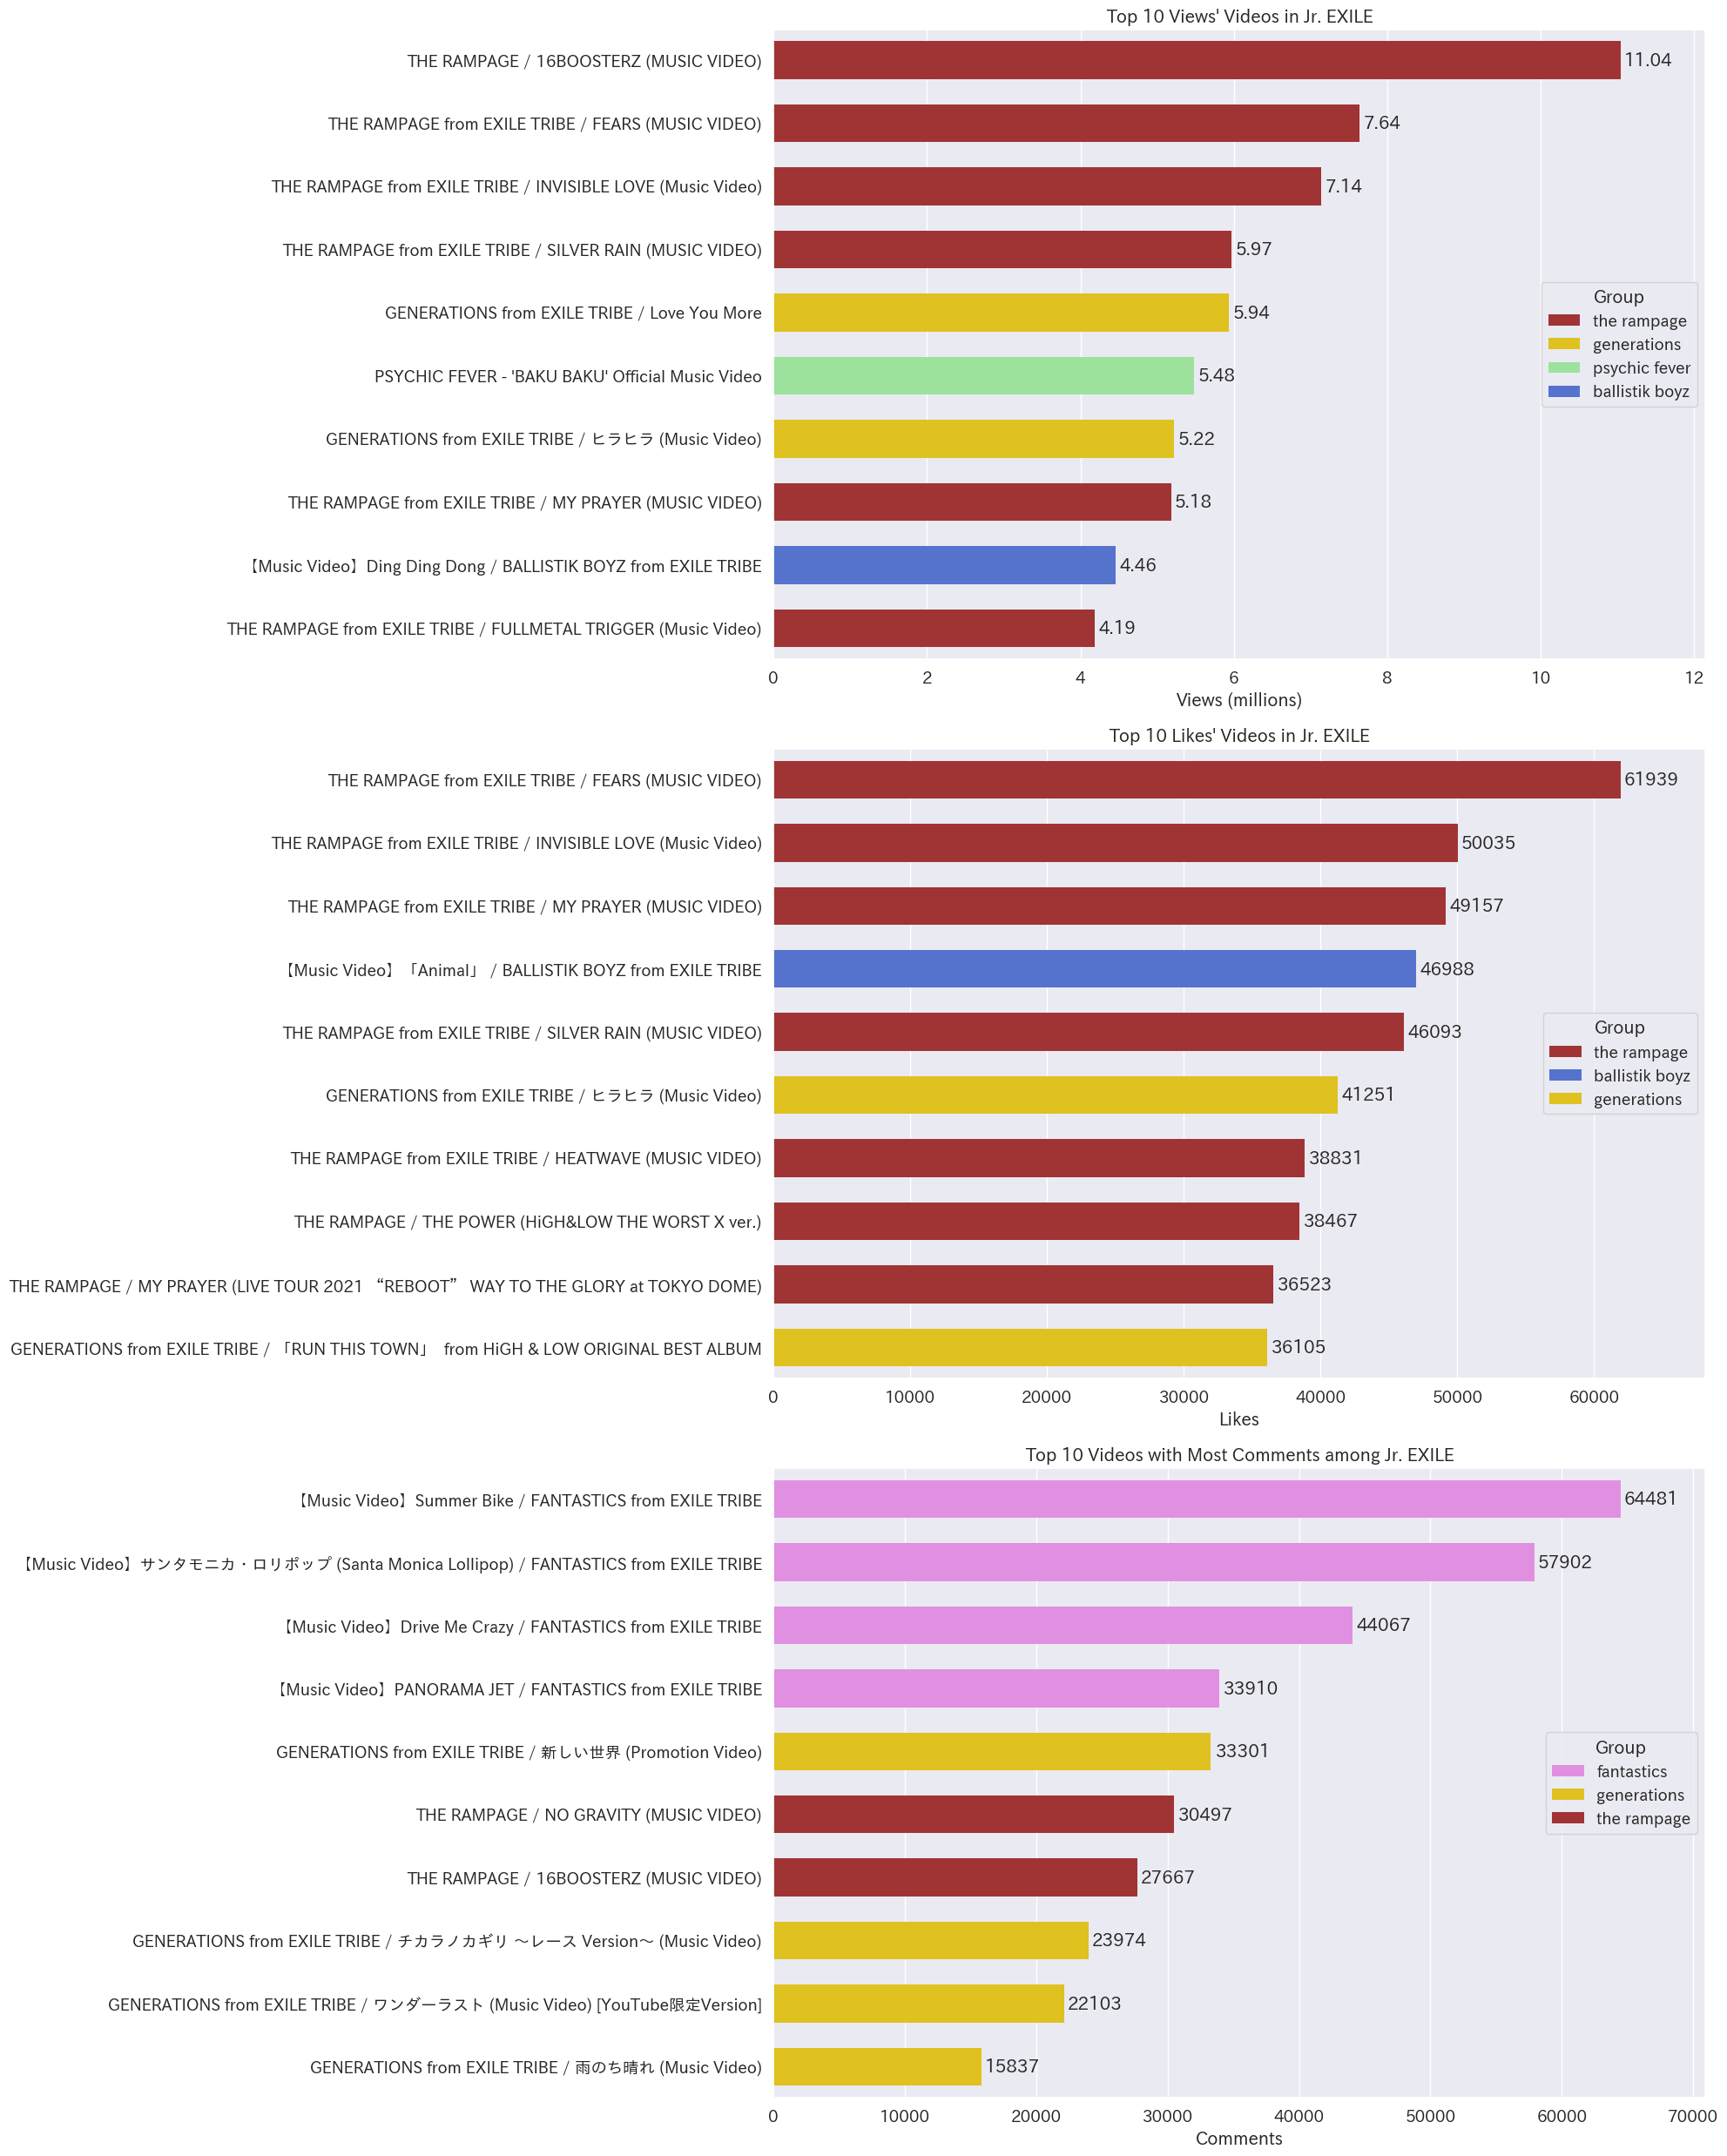

In [ ]:
sns.set_theme(palette='Set2', font="IPAexGothic", font_scale=1.2)
palette={'generations': 'gold',
         'the rampage': 'firebrick',
         'fantastics': 'violet',
         'ballistik boyz': 'royalblue',
         'psychic fever': 'lightgreen'}

fig, ax = plt.subplots(3, 1, figsize=(20, 25))


def top10_barplot(data, ax, x, xlabel, title):
  # dodge=True 表示 bar 會依據類別平移
  sns.barplot(data=data, ax=ax, x=x, y='video_name', hue='channel',
              palette=palette, dodge=False, width=0.6, linewidth=0)
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel('')
  ax.legend(loc='center right', title='Group')
  for bars_group in ax.containers:
    ax.bar_label(bars_group, padding=3) # 將數據標籤到bar上
  ax.margins(x=0.1, y=0.02) # 邊距加大


top10_barplot(top10views_videos, ax[0], 'views_million', 'Views (millions)', 'Top 10 Views\' Videos in Jr. EXILE')
top10_barplot(top10likes_videos, ax[1], 'likes', 'Likes', 'Top 10 Likes\' Videos in Jr. EXILE')
top10_barplot(top10comments_videos, ax[2], 'comments', 'Comments', 'Top 10 Videos with Most Comments among Jr. EXILE')

# sns.despine() # 移除上方、右方的axes
plt.tight_layout() # 避免subplot之間重疊
plt.show()

*   看次數前十名：有 7 支影片是 THE  RAMPAGE 的 music videos；2 支影片是 GENERATIONS 的 music video；1 支是 PSYCHIC FEVER 的 music video。觀看次數最多的前五名，THE RAMPAGE 就佔了四名，並且最高的 16BOOSTERS 遠遠超過其他影片三四百萬的觀看次數。
*   獲得的喜歡的次數前十名：有 7 支影片是 THE RAMPAGE 的影片，大多是 music videos，一支是現場影片；2 支影片是 GENERATIONS 的影片，應該都是 music video；1 支是 BALLISTIK BOYZ 的 music video。前五名，THE RAMPAGE 就佔了四名，並且最高的 FEARS 獲得的 likes量比其他影片多了一萬多。
*   留言數量前十名：FANTASTICS 的四支 music videos 擁有最多的留言數量，GENERATIONS 有 4 支，THE RAMPAGE 佔了 2 支

結果挺有意思的
*   首先，THE RAMPAGE 表現真的很好，不少音樂影片觀看次數跟被喜歡的次數常常最多。
*   GENERATIONS 表現穩定，在 views, likes, comments 都是。
*   新團 PSYCHIC FEVER 歌雖少，但一首新歌觀看次數居然高達五百多萬
*   BALLISTIK BOYZ 也有一首新歌有四百多萬的觀看次數， 一支兩年前的 music video 得到 4 萬多的喜歡
*   最有趣的是 FANTASTICS 的結果，沒有單支影片進觀看次數或喜歡次數的前十，然而，影片下方的留言量遠遠超過其他團。

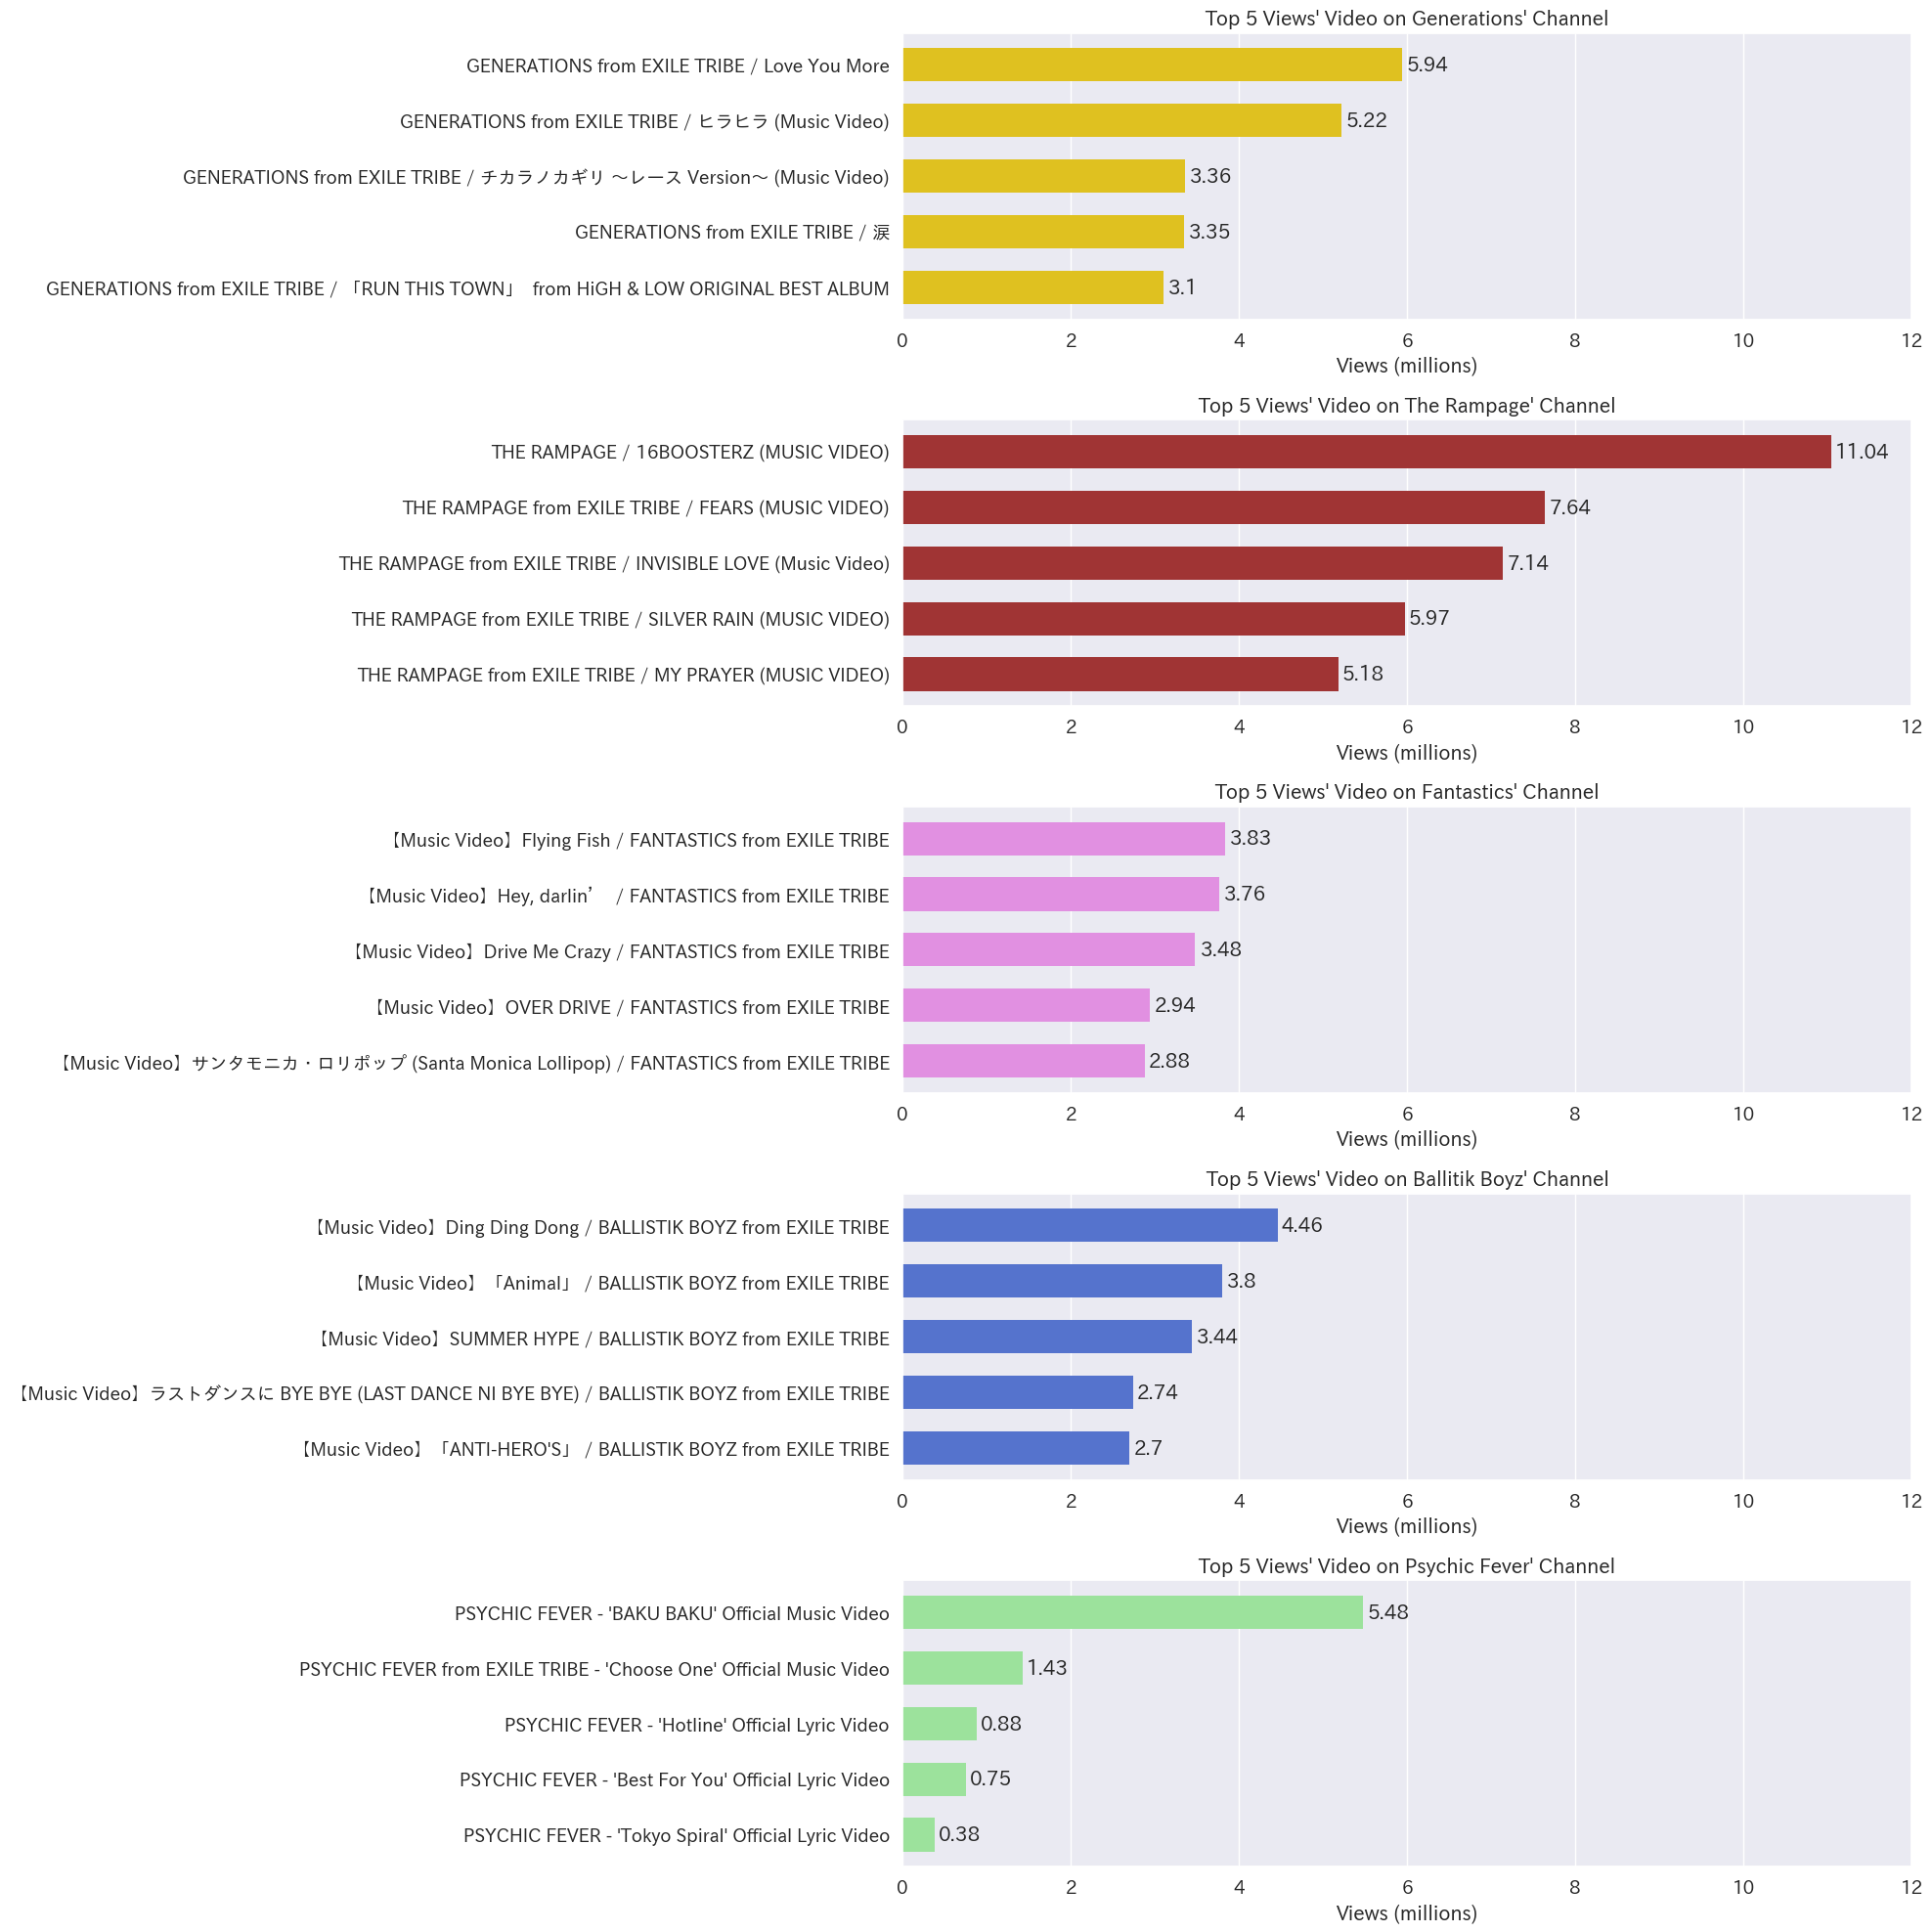

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(20, 20))

def views_barplot(data, ax, color, title):
  sns.barplot(data=data, ax=ax, x='views_million', y='video_name',
              color=color, width=0.6, linewidth=0)
  ax.set_title(title)
  ax.set_xlabel('Views (millions)')
  ax.set_ylabel('')
  for bars_group in ax.containers:
    ax.bar_label(bars_group, padding=3)
  ax.margins(x=0.1)
  ax.margins(y=0.06)
  ax.set_xlim(0,12)


views_barplot(top5views_gene, ax[0], palette.get('generations'), 'Top 5 Views\' Video on Generations\' Channel')
views_barplot(top5views_rampage, ax[1], palette.get('the rampage'), 'Top 5 Views\' Video on The Rampage\' Channel')
views_barplot(top5views_fanta, ax[2], palette.get('fantastics'), 'Top 5 Views\' Video on Fantastics\' Channel')
views_barplot(top5views_BBZ, ax[3], palette.get('ballistik boyz'), 'Top 5 Views\' Video on Ballitik Boyz\' Channel')
views_barplot(top5views_PCF, ax[4], palette.get('psychic fever'), 'Top 5 Views\' Video on Psychic Fever\' Channel')


plt.tight_layout()
plt.show()

各團觀看次數最多的都是音樂影片，只有 PSYCHIC FEVER 有三支歌詞影片。

大致上，THE RAMPAGE 在五百、七百、甚至破千萬觀看次數。GENERATIONS 在三五百萬這樣。FANTASTICS、BALLISTIK BOYZ 兩團看起來差不多，略少於 GENERATIONS，但也都在兩三百萬觀看次數。PSYCHIC FEVER 雖然大多未到百萬觀看次數，但一首新歌在短時間內遠遠超過 FANTASTICS 跟 BALLISTIK BOYZ，快追上 GENERATIONS，潛力十足的新團。

然而，一個使用者可能貢獻大於一的觀看次數，而一個使用者只能按一次喜歡，接下來來看看 likes 數能給我們什麼 insights

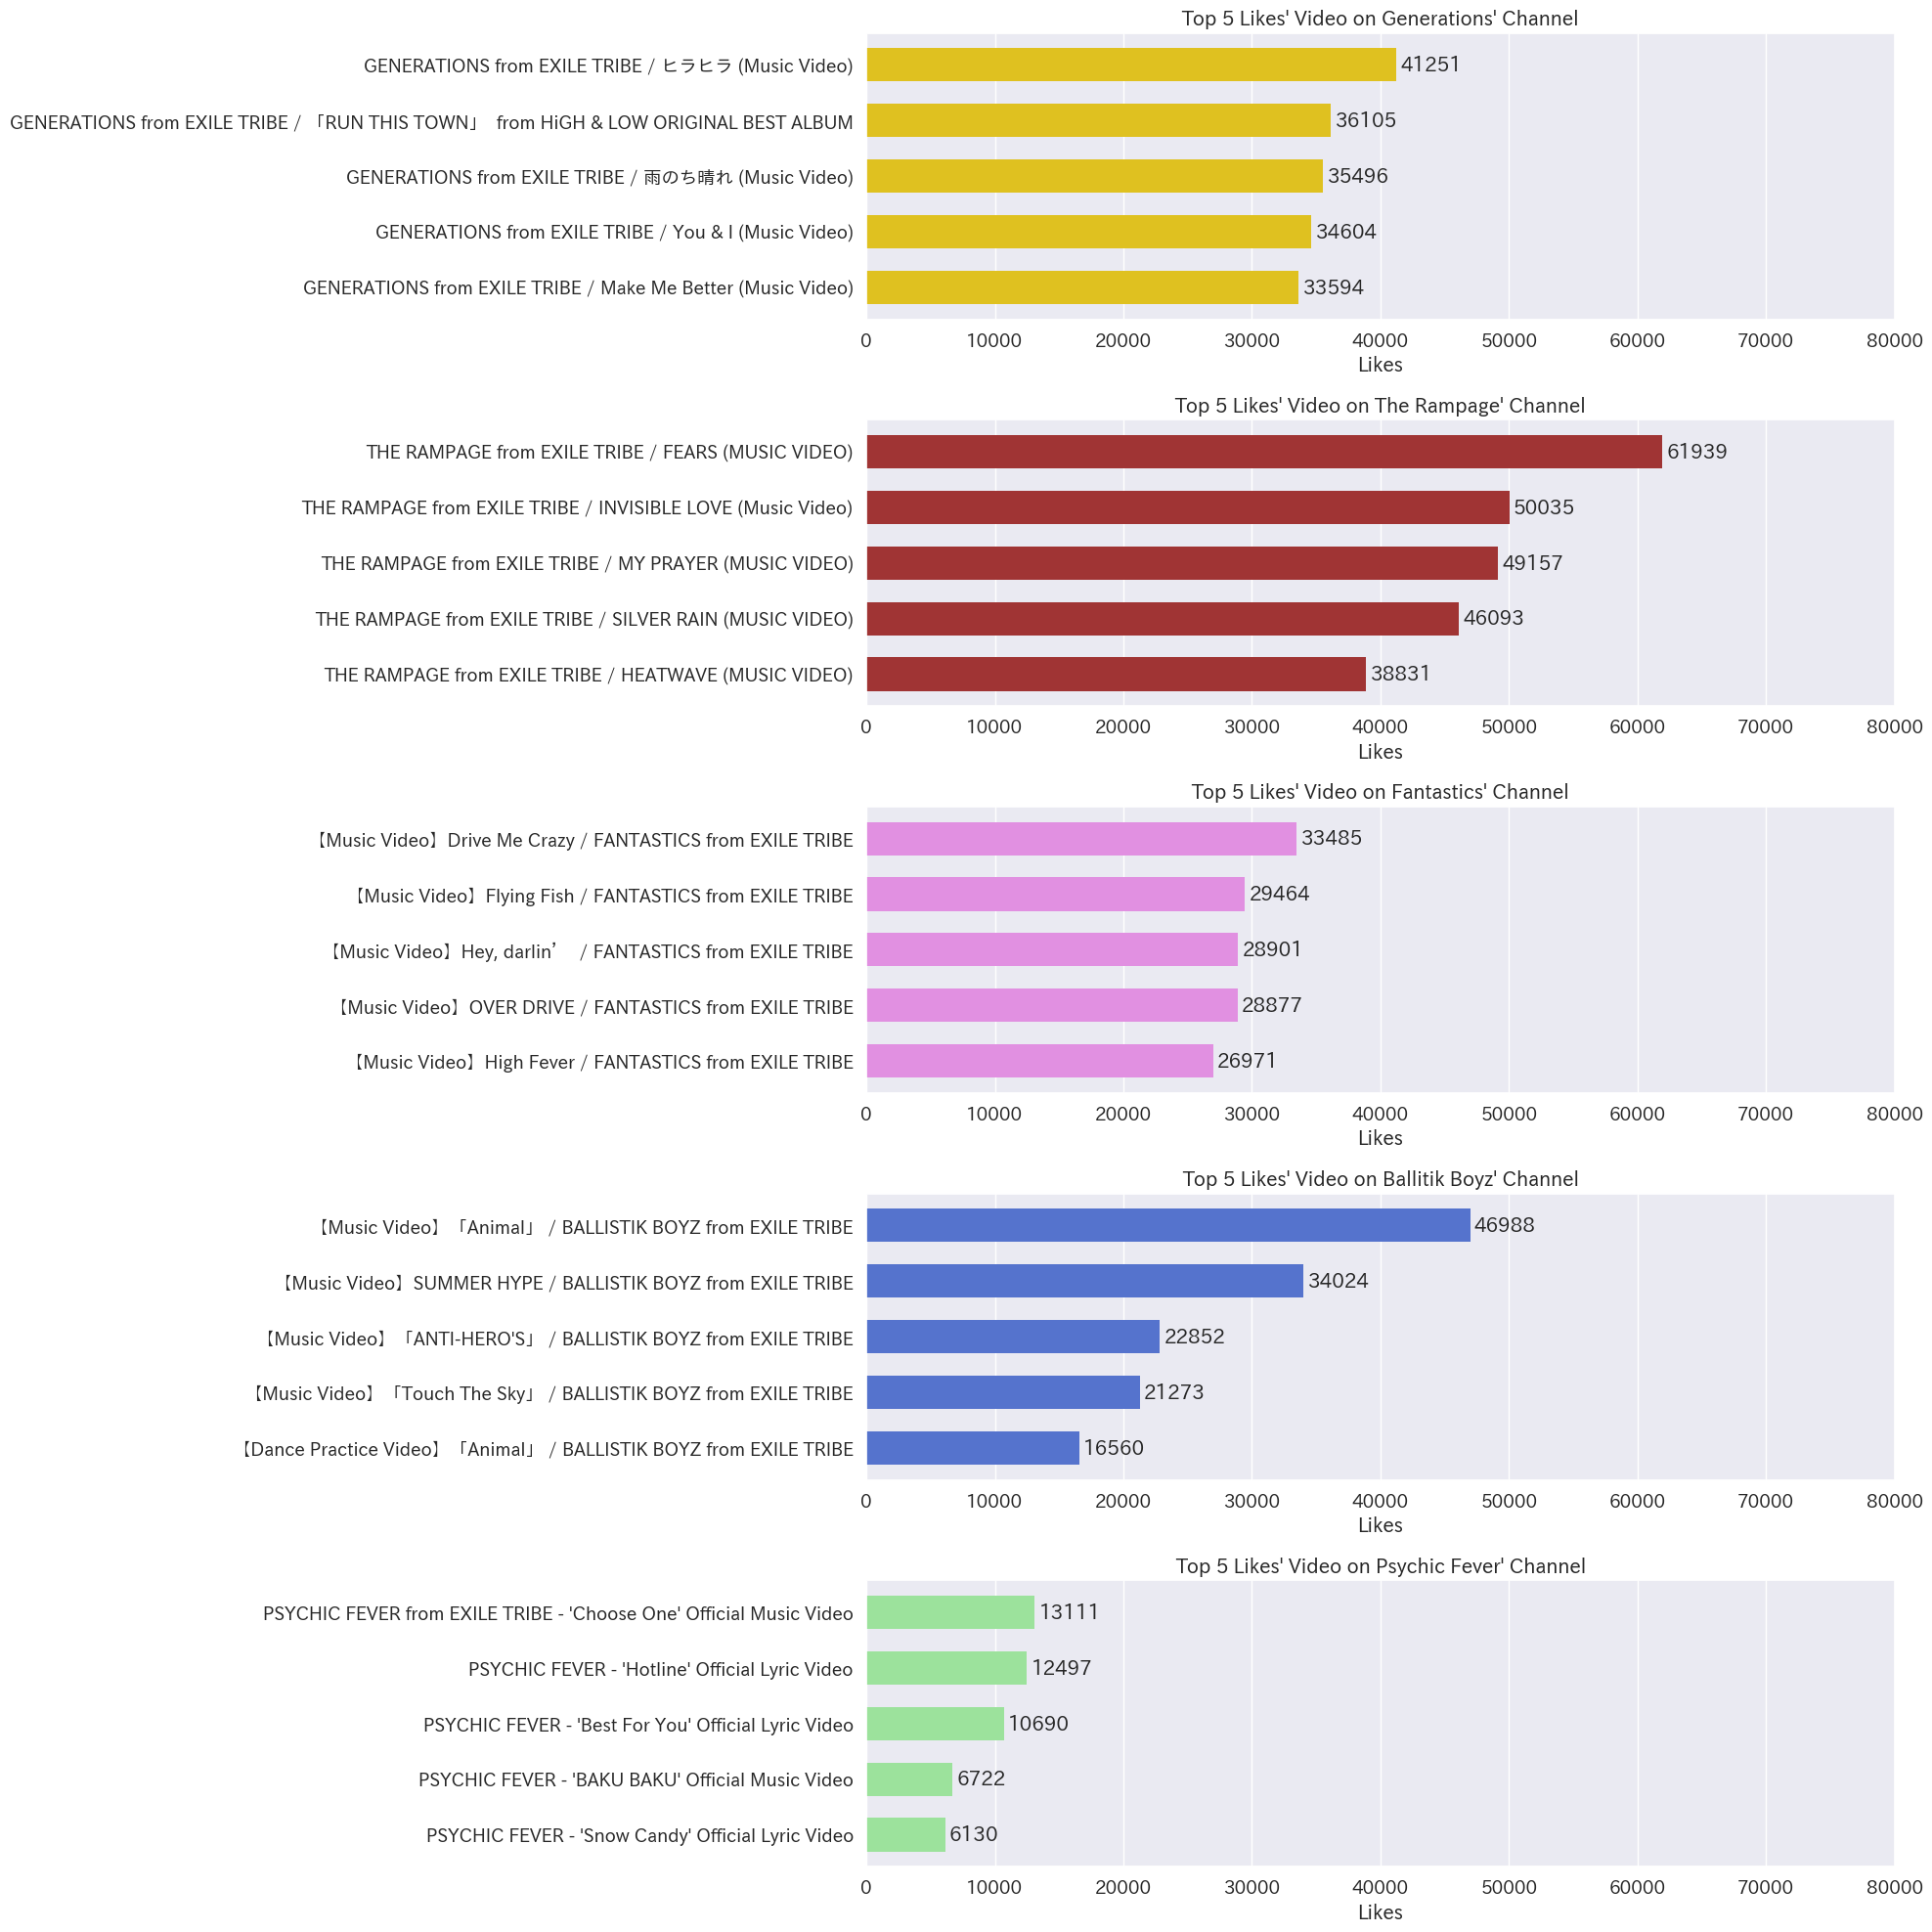

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(20, 20))

def likes_barplot(data, ax, color, title):
  sns.barplot(data=data, ax=ax, x='likes', y='video_name',
              color=color, width=0.6, linewidth=0)
  ax.set_title(title)
  ax.set_xlabel('Likes')
  ax.set_ylabel('')
  for bars_group in ax.containers:
    ax.bar_label(bars_group, padding=3)
  ax.margins(x=0.1)
  ax.margins(y=0.06)
  ax.set_xlim(0,80000)


likes_barplot(top5likes_gene, ax[0], palette.get('generations'), 'Top 5 Likes\' Video on Generations\' Channel')
likes_barplot(top5likes_rampage, ax[1], palette.get('the rampage'), 'Top 5 Likes\' Video on The Rampage\' Channel')
likes_barplot(top5likes_fanta, ax[2], palette.get('fantastics'), 'Top 5 Likes\' Video on Fantastics\' Channel')
likes_barplot(top5likes_BBZ, ax[3], palette.get('ballistik boyz'), 'Top 5 Likes\' Video on Ballitik Boyz\' Channel')
likes_barplot(top5likes_PCF, ax[4], palette.get('psychic fever'), 'Top 5 Likes\' Video on Psychic Fever\' Channel')

plt.tight_layout()
plt.show()

大部分也都是 music video ，BALLISTIK BOYS 的 Animal 的 music video 跟 dance version 都在likes前五， PSYCHIC FEVER 有三支 lyric video。

大致上，likes數在各組內還滿平均的，可能意味著按下like的使用者重疊性很高，也就是像我一樣幾乎每一支 FANTASTICS 我都會按喜歡。因為不像觀看次數，一個使用者可能貢獻大於一的觀看次數，like一個使用者只能按一次，YouTube 目前好像沒有這個數據。比較特別的是，各組內特別高的影片，例如 THE RAMPAGE 的 FEARS 跟 BALLISTIK BOYZ 的 Animal 可能吸引到了粉絲以外的路人觀眾。

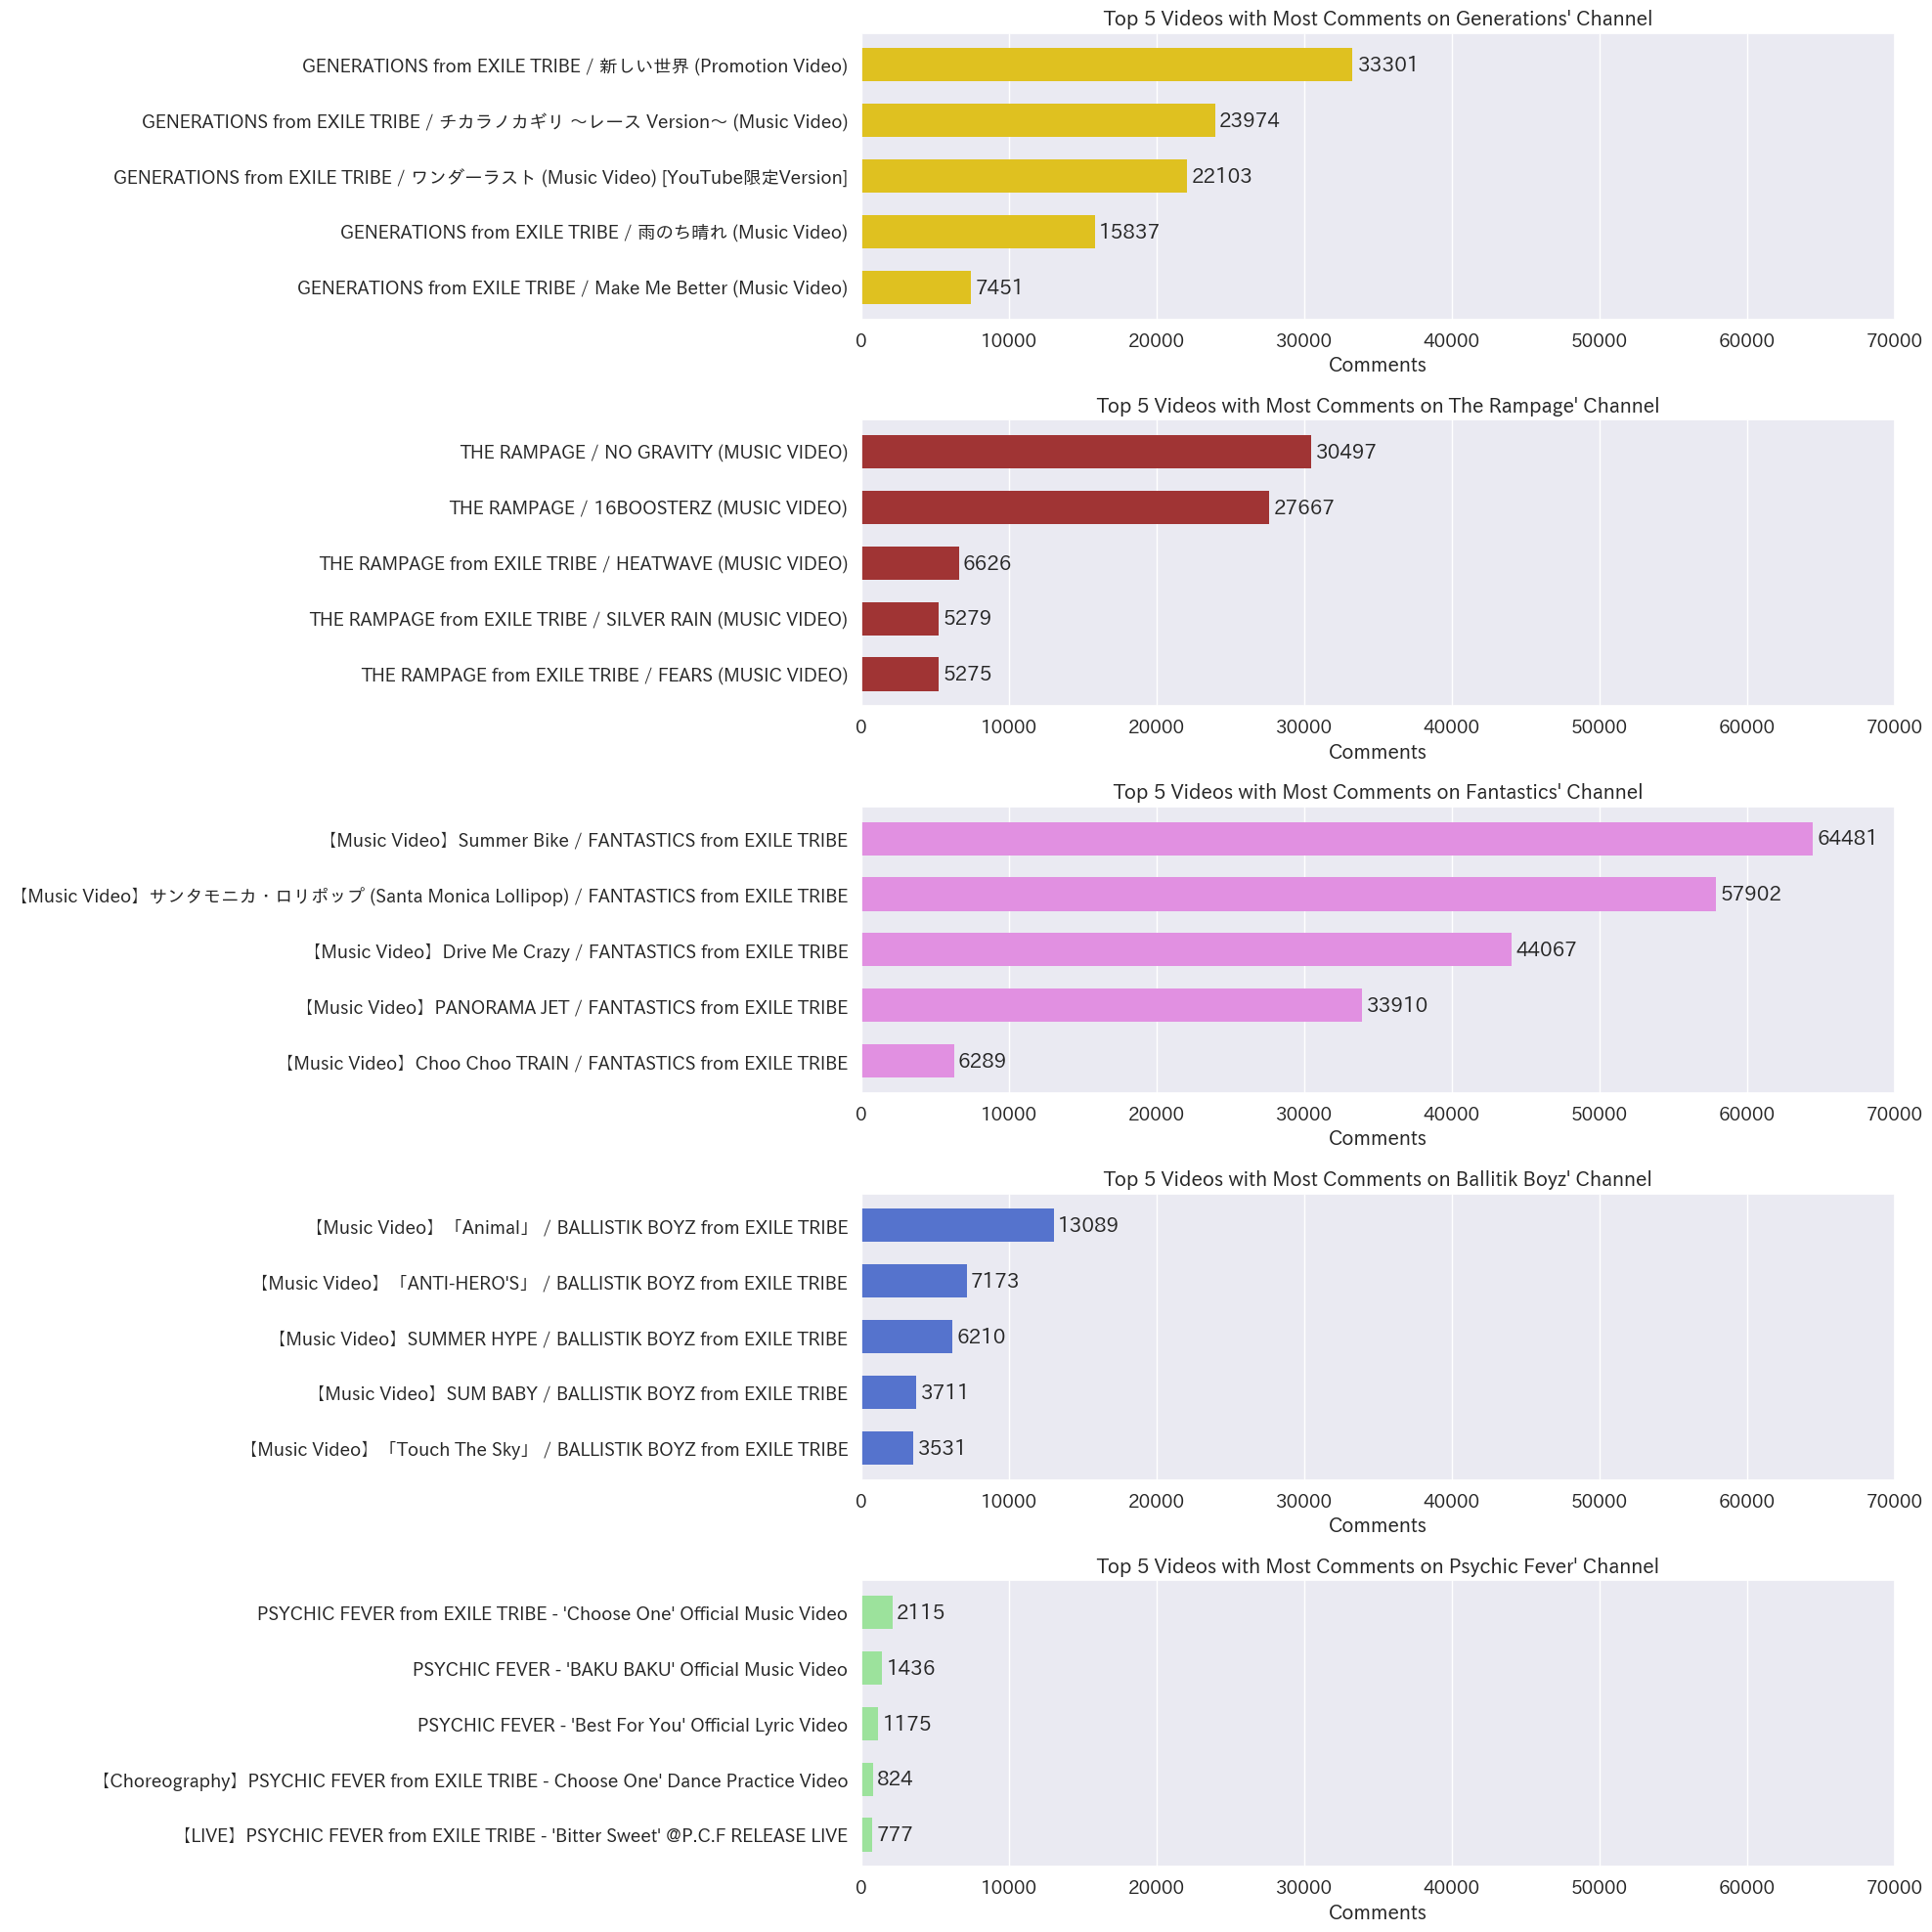

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(20, 20))


def comments_barplot(data, ax, color, title):
  sns.barplot(data=data, ax=ax, x='comments', y='video_name',
              color=color, width=0.6, linewidth=0)
  ax.set_title(title)
  ax.set_xlabel('Comments')
  ax.set_ylabel('')
  for bars_group in ax.containers:
    ax.bar_label(bars_group, padding=3)
  ax.margins(x=0.1)
  ax.margins(y=0.06)
  ax.set_xlim(0,70000)


comments_barplot(top5comments_gene, ax[0], palette.get('generations'), 'Top 5 Videos with Most Comments on Generations\' Channel')
comments_barplot(top5comments_rampage, ax[1], palette.get('the rampage'), 'Top 5 Videos with Most Comments on The Rampage\' Channel')
comments_barplot(top5comments_fanta, ax[2], palette.get('fantastics'), 'Top 5 Videos with Most Comments on Fantastics\' Channel')
comments_barplot(top5comments_BBZ, ax[3], palette.get('ballistik boyz'), 'Top 5 Videos with Most Comments on Ballitik Boyz\' Channel')
comments_barplot(top5comments_PCF, ax[4], palette.get('psychic fever'), 'Top 5 Videos with Most Comments on Psychic Fever\' Channel')

plt.tight_layout()
plt.show()

觀眾最常留言的影片大多是音樂影片，PSYCHIC FEVER 有一支歌詞影片、一支舞蹈影片、一支現場影片。

大致上，GENERATIONS 影片的留言數量較 THE RAMPAGE 多， BALLISTIK BOYZ 跟 PSYCHIC FEVER 相對稀少。最有趣的是 FANTASTICS 影片的留言數量遠遠超過其他團體，可能有什麼特別的原因，但僅就留言數量無從得知。

以上是量化分析，數據能提供的更細節的資訊就要透過質化分析了，例如，影片下方的留言內容。

## Step 7. by video type: analysis + plots-> conclusion + next step

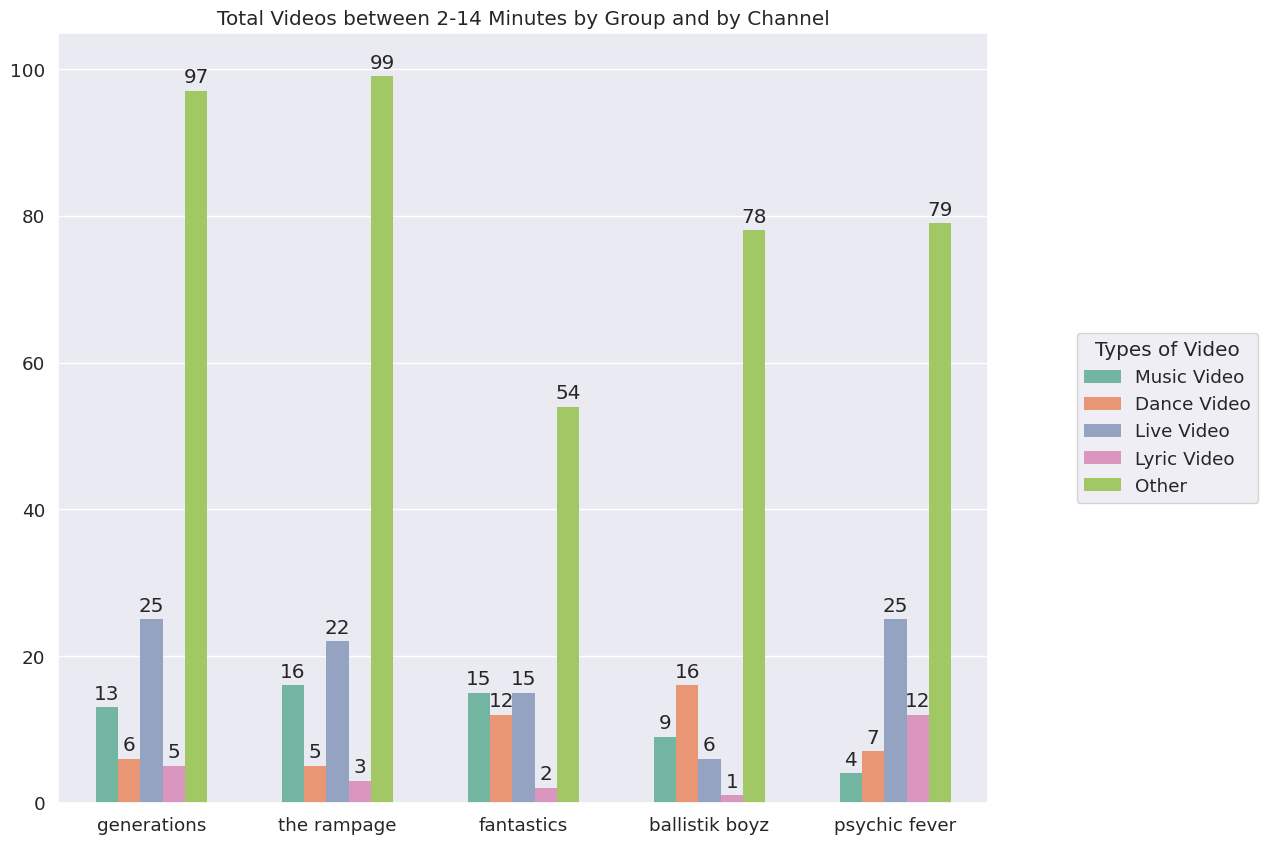

In [ ]:
sns.set_theme(palette='Set2', font_scale=1.2)
palette={'generations': 'gold',
         'the rampage': 'firebrick',
         'fantastics': 'violet',
         'ballistik boyz': 'royalblue',
         'psychic fever': 'lightgreen'}
types_order = ['Music Video', 'Dance Video', 'Live Video', 'Lyric Video', 'Other']
fig, ax = plt.subplots(figsize=(12, 10))

sns.barplot(data=groups_result_df, ax=ax,
            x='channel', y='views',
            hue='type_video', hue_order=types_order,
            width=0.6, linewidth=0)
ax.set_title('Total Videos between 2-14 Minutes by Group and by Channel')
ax.set_xlabel('')
ax.set_ylabel('')
for bars_group in ax.containers:
  ax.bar_label(bars_group, padding=3)
ax.margins(y=0.06)
ax.legend(loc='center right', bbox_to_anchor=(1.3,0.5), title='Types of Video')

plt.show()

很明顯 Other 這個類別在每個頻道都有最多的影片，例如 behind the scenes, teaser etc.，但不是我主要要分析的目標。

其他 4 個類型在每個團體的 pattern 不太一樣。因為影片數量會影響之後的對 views/ likes/ comments 的分析，所以這邊簡單的討論一下

*   GENERATIONS 不一定把影片的類型放在標題，所以可能分類沒有很成功

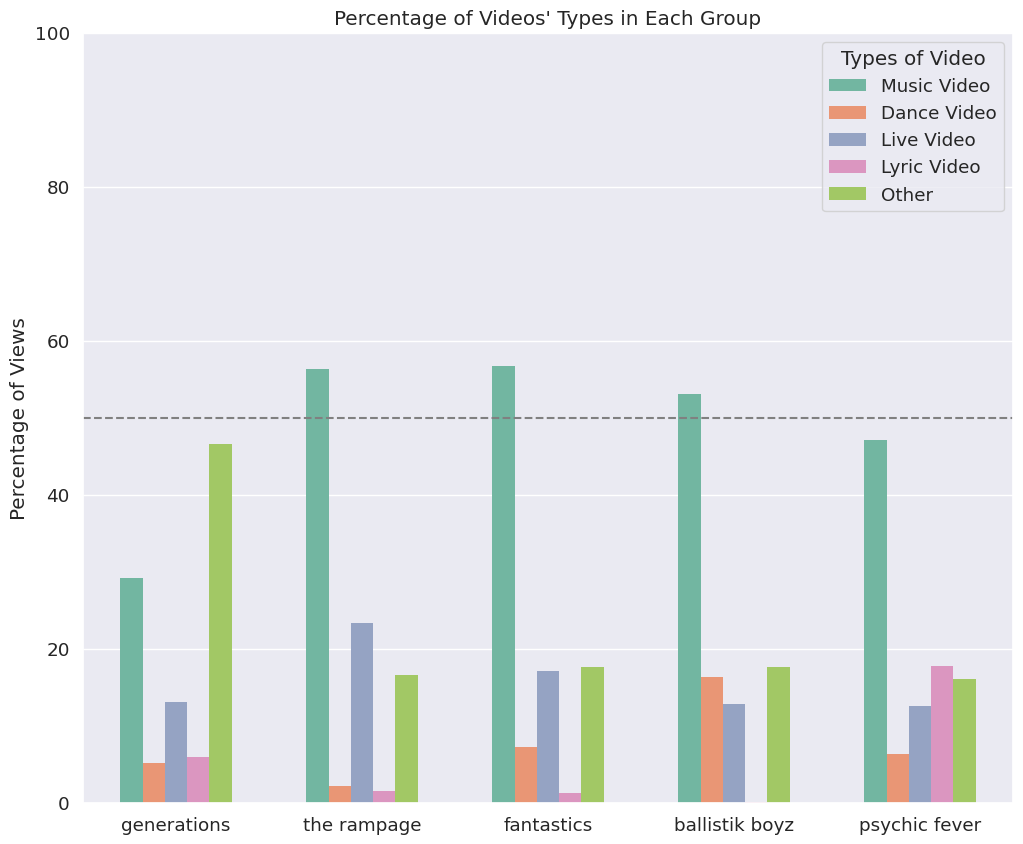

In [ ]:
sns.set_theme(palette='Set2', font_scale=1.2)

def percViews_bar(df, y, title, ylabel):
  types_order = ['Music Video', 'Dance Video', 'Live Video', 'Lyric Video', 'Other']

  fig, ax = plt.subplots(figsize=(12, 10))

  sns.barplot(data=df, x='channel', y=y,
              hue='type_video', hue_order=types_order, width=0.6, linewidth=0)
  ax.set_title(title)
  ax.set_xlabel('')
  ax.set_ylabel(ylabel)
  ax.legend(loc='upper right', title='Types of Video')
  ax.set_ylim(0,100)
  ax.axhline(50, ls='--', color='gray')
  # for bars_group in ax.containers:
  #   ax.bar_label(bars_group, padding=3)


percViews_bar(percViews_groupby_df, 'percentageViews', 'Percentage of Videos\' Types in Each Group', 'Percentage of Views')

plt.show()



*   GENERATIONS 的頻道在這個專案的分類方法真的分失敗了，可以看到大部分的觀看次數都跑到 Other 了，不少 music videos 或 live 被分類到 Other
*   THE RAMPAGE 頻道的觀看次數超過一半在 music videos，約 25% 在 live videos， dance & lyric 相對稀少
*   FANTASTICS 頻道的觀看次數超過一半在 music videos，live videos 的觀看次數約 18%，dance 約 8%，lyric 相對稀少
*   BBZ 頻道也是超過一半的觀看次數都在 music videos，但他們 dance videos 的觀看次數約 17%，live videos 約 15%
*   PCF 頻道的觀看次數將近一半在 music videos，接著是 lyric, live, dance

除了 music videos 一直是觀眾最喜歡看的， THE RAMPAGE 的 live 也很強勢，dance & lyric 相對稀少。FANTASTICS 頻道的觀看次數超過一半在 music videos，live videos 的觀看次數約 18%，dance 約 8%，lyric 相對稀少。BALLISTIK BOYZ 頻道也是超過一半的觀看次數都在 music videos， live 跟 dance version 則都受歡迎，甚至 dance version 還超過 live。PSYCHIC FEVER 反而是 lyric videos 佔的觀看次數較多。

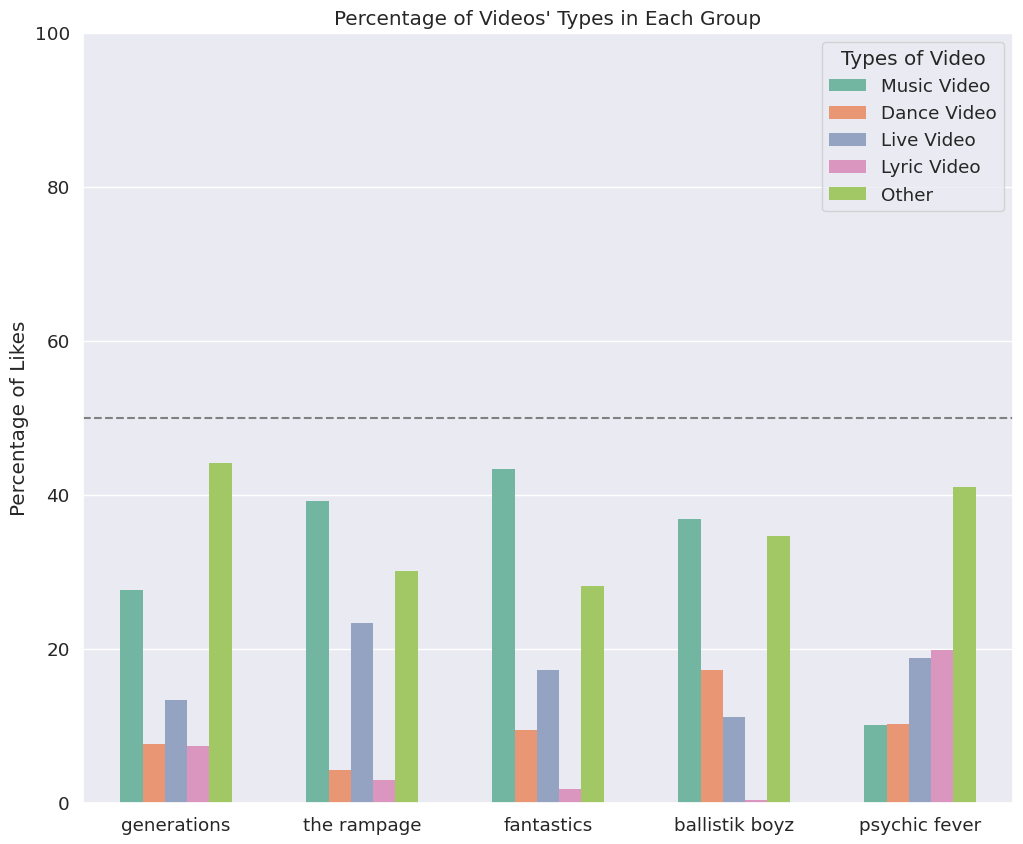

In [ ]:
percViews_bar(percLikes_groupby_df, 'percentageLikes', 'Percentage of Videos\' Types in Each Group', 'Percentage of Likes')

plt.show()

likes 各類型影片所佔比例的 pattern 跟 views 相似。

不過可以注意到的是，music videos 在 likes 數量的比例沒有像 views 有過半的（y=50 的那條虛線）。唯一明顯跟 views 的 pattern 不同的是 PSYCHIC FEVER 的頻道， music videos 的 likes 變成比例最少的類型。

我認為的可能原因有兩種

1.   同一批使用者重複看相同的影片，但一個使用者只能按一次 like
2.   另一種可能解釋是，某些 music videos 觸及到非常多使用者，而他們看了影片後，沒有按 like。目前的數據無法回答這個問題。

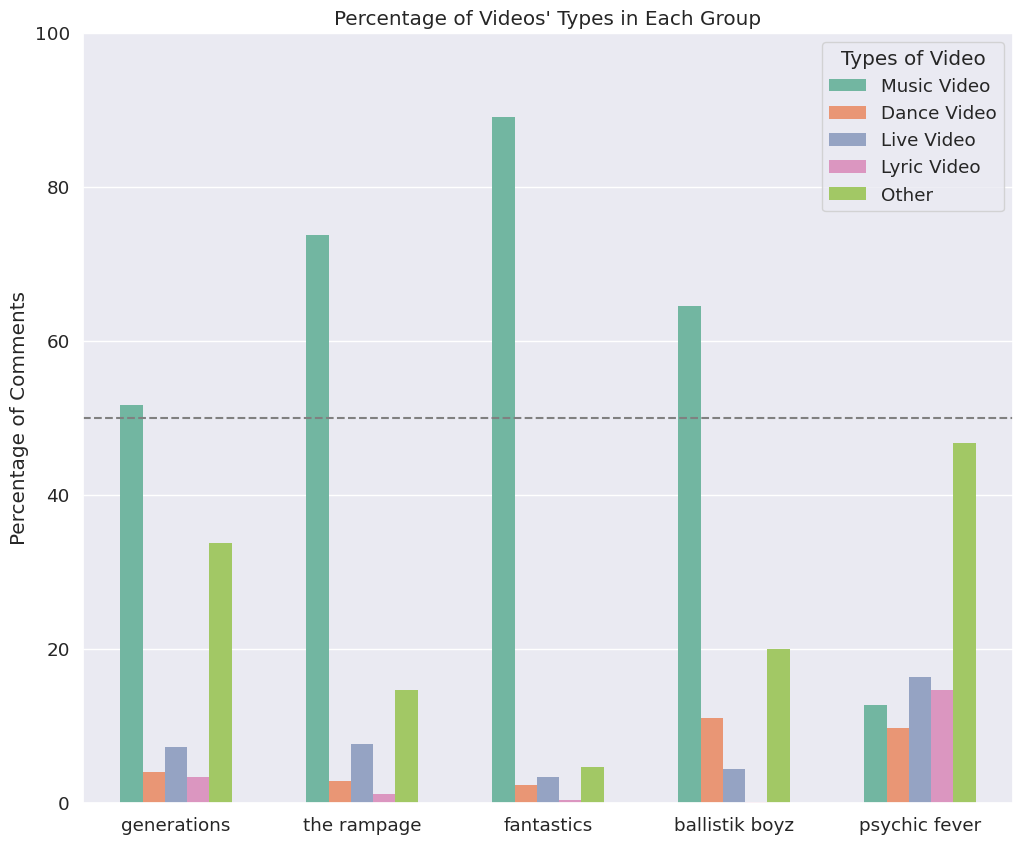

In [ ]:
percViews_bar(percComments_groupby_df, 'percentageComments', 'Percentage of Videos\' Types in Each Group', 'Percentage of Comments')

plt.show()

首先，comments 的各類型影片所佔比例的 pattern 跟其他指標相似但更極端。

相較於 views 僅僅是被動的觀看，或是 likes 是按一下按鍵，comments 是主動的留下心得或心情，我認為是更粉絲取向的行為，也有一點想互動的傾向，會留下留言的這類粉絲也許更加忠誠（或狂熱？）。

大多也是在 music videos 的留言最多


*   GENERATIONS 分類失敗不討論 QQ
*   THE RAMPAGE 跟 BALLISTIK BOYZ 頻道的 pattern 跟 FANTASTICS 的頻道很像，但分佈比較沒那麼極端
*   很有趣的是，FANTASTICS 頻道數據分佈相當極端，九成留言都落在 music videos。作為平均顏值最高的團體（自我定位是聰明美麗😂），也許、可能顏粉比例不少，想知道留言的內容是否也是這類的留言居多？
*   BALLISTIK BOYZ 頻道也是超過一半的觀看次數都在 music videos，但他們 dance videos 都還佔 10% 的留言量
*   PSYCHIC FEVER 頻道除了將近一半在 other ，其他類型的影片的留言量倒是挺平均

也有可能是不同團的粉絲行為就不同，或者就是不同特質的團體吸引到的粉絲不同（粉絲文化也是相當複雜的）